In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

# background実行

TODO
1. run()で実行テストしたWorkChainの子クラスをファイルに置く。
1. pipを用いてverdiのpluginに登録する。
1. verdi daemonをrestartする。

## すでにrun()で実行テストしたWorkChainの子クラスをファイルに置く。

stableposition/に置いた。
```
stablepositon/
stablepositon/common/workflow/energy.py
stablepositon/common/workflow/force.py
stablepositon/steepestdescnt/workflow/new_x.py
```
その他にも__init__.pyやsetup.*を置かねばならない。

## pipを用いてverdiのpluginに登録する。
### setup.json

setup.jsonは以下のように書く。
```json
{
    "name" : "stablex",
    "version" : 0.1,
    "author" : "Hiori Kino",
    "entry_points" : {
       "aiida.workflows": [
           "stablex.sd_new_x = steepestdescent.workflows.new_x: NewXChain",
           "stablex.energy = common.workflows.energy: EnergyChain",
           "stablex.force = common.workflows.force: ForceChain"
       ]
    }
}
```
- "stablex.sd_new_x"がaiida側での識別に用いる文字列
- "steepestdescent.workflows.new_x: NewXChain"がsteepestdescent/workflows/new_x.pyにあるNewXChainクラス
であることを示す。

## pip install
local directory下のファイルを用いるeditable modeでinstallしてみる。
steepestdescent/ directoryで
```sh
$ pip install -e .
```
を実行するとlocal directory下がPython環境に登録される。

上のコマンドは
/home/max/.virtualenvs/aiida/lib/python3.7/site-packages/
stablex.egg-link
を作成する。
このファイルの中身はinstall directory
/home/max/Documents/aiida_primer_v2/2.SteepestDescent/stableposition
を示している。


# daemonをrestartする。

このままではAiiDA daemonが認識しない。

```sh
$ verdi daemon status
```
でdaemonが起動しているのかを確認する。
daemonがすでに起動していれば
```sh
$ verdi daemon restart
```
と再起動する。
daemonが起動していなければ
```sh
$ verdi daemon start
```
として起動する。上のコマンド一回では起動しないかもしれない。
```sh
$ verdi daemon status
```
で起動していることを確認する。


### daemonがWorkChainを認識したことを確認する。
とする。上で定義したpluginがaiida.workflowsなので
```sh
$ verdi plugin list aiida.workflows 
```
setup.jsonが間違っていなければ、出力は
```console
...
* siesta.stm
* stablex.energy  
* stablex.force 
* stablex.sd_new_x 
* tbmodels.parse
...
```
などと表示される。

更に、Python scriptが間違っていなければ、それぞれのコードの入出力とエラーが
```sh
verdi plugin list aiida.workflows stablex.energy 
```
の出力は
```console
Description:

	No description available

Inputs:
         x:  required  Float  
  metadata:  optional         
Outputs:
    energy:  required  Float  
Exit codes:
         1:  The process has failed with an unspecified error.
         2:  The process failed with legacy failure mode.
        10:  The process returned an invalid output.
        11:  The process did not register a required output.
```
と出力される。上で、No description availableとなっているのは詳細を書いていないからである。
Exit codesはWorkChainですでに定義されているcodeが表示されている。

In [2]:
!verdi plugin list aiida.workflows

Registered entry points for aiida.workflows:
* castep.altrelax
* castep.bands
* castep.base
* castep.relax
* core.arithmetic.add_multiply
* core.arithmetic.multiply_add
* quantumespresso.matdyn.base
* quantumespresso.pdos
* quantumespresso.ph.base
* quantumespresso.pw.bands
* quantumespresso.pw.base
* quantumespresso.pw.relax
* quantumespresso.q2r.base
* stablex.energy
* stablex.force
* stablex.sd_new_x
* stablex2.energy
* stablex2.force
* stablex2.sd_new_x
* stablex2.stable_x
* vasp.bands
* vasp.converge
* vasp.immigrant
* vasp.master
* vasp.neb
* vasp.relax
* vasp.vasp
* vasp.verify

Report: Pass the entry point as an argument to display detailed information


verdiとして実行しているが、これはAiiDAの機能ではなく、Pythonの機能を用いている。
（そのため、pip installをすることで使えるようになる機能である。）

In [3]:
!verdi plugin list aiida.workflows stablex.energy

Description:

    No description available

Inputs:
       x  Float
metadata

Required inputs are displayed in bold red.

Outputs:
energy  Float

Required outputs are displayed in bold red.

Exit codes:

 0  The process finished successfully.
 1  The process has failed with an unspecified error.
 2  The process failed with legacy failure mode.
10  The process returned an invalid output.
11  The process did not register a required output.

Exit codes that invalidate the cache are marked in bold red.



# jupyter kernelのrestart
daemon がrestartしても起動しても、
すでに起動したPython kernelは設定の変化を反映されない。
jupyter notebookのPython kernelもrestartする。

In [4]:
from aiida.plugins import WorkflowFactory
from aiida.orm import Float, load_node
from aiida.engine import run,submit,workfunction
import numpy as np
import time

"stablex.energy = common.workflows.energy: EnergyChain"の部分のloadを行い、実行してみる。

まずPythonから直接importしてrun実行してみる。(scriptのdebug時もrunで実行できる。）

In [5]:
from stableposition.common.workflows.energy import EnergyChain

result,node = run.get_node(EnergyChain, x=Float(2.0))
result, node

{'energy': <Float: uuid: 023f84d4-a394-4176-b78b-774d11558b8e (pk: 9084) value: 4.0>}

In [6]:
# 念のためimport定義を消去しておく。(AiiDAでなくPythonの機能である。)
del EnergyChain

WorkflowFactoryを利用して実行してみる。
WorkflowFactory経由で実行するのはPythonのdaemonがそのPythonの実行にPythonのentrypoint機能を用いるためである。

In [7]:
energychain = WorkflowFactory("stablex.energy")
builder = energychain.get_builder()
builder.x = Float(2.0)
result, node = run.get_node(builder)
result, node

{'energy': <Float: uuid: c7d98201-a2f2-4a93-922a-293bc324c6c0 (pk: 9088) value: 4.0>}

## Errorが起きた場合
おそらく、entrypointがおかしくなっている。これはAiiDAでなく、Pythonの問題である。

1. uninstall
```sh
$ pip uninstall 該当module
```

2. daemon restart
```sh
$ verdi daemon restart --reset
```

3. reentry scan
```sh
$ reentry scan
```
を繰り返す。

## directoryを移動させてしまった場合
`pip install -e .`したdirectoryを移動させてしまった場合は
Python scriptをinstallしたdirectoryで
/home/max/.virtualenvs/aiida/lib/python3.7/site-packages/
stablex.egg-link
自体を削除する。

aiidaのdirectoryは、たとえば、

In [8]:
import aiida
aiida.__file__

'/home/kino/miniconda3/envs/aiida/lib/python3.10/site-packages/aiida/__init__.py'

などとして調べることができる。

AiiDAの使い方に戻り、結果の表示を行う。

In [9]:
print(type(result),result["energy"])

<class 'dict'> uuid: c7d98201-a2f2-4a93-922a-293bc324c6c0 (pk: 9088) value: 4.0


実績グラフの表示

Success: Output written to `9088.dot.pdf`


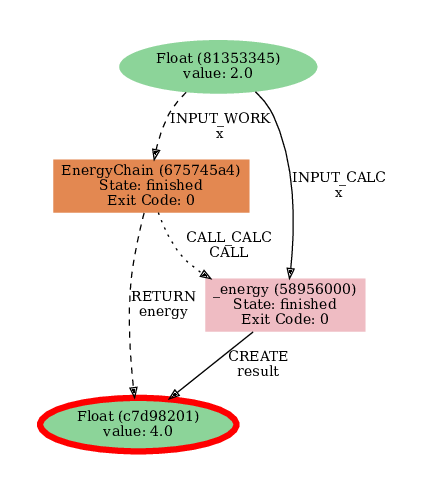

In [10]:
import subprocess
pk = result["energy"].pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

submit()によりbackground実行を行う。

In [11]:
energychain = WorkflowFactory("stablex.energy")
builder = energychain.get_builder()
builder.x = Float(2.0)
result = submit(builder)
result

<WorkChainNode: uuid: 18fdb7ab-7c62-4680-9acb-126ab0b08d5b (pk: 9090) (aiida.workflows:stablex.energy)>

以下で終了したか、をチェックする。

In [12]:
future = submit(builder)
while not future.is_finished:
    print(future.is_finished)
    time.sleep(1)
print(future.is_finished_ok)
print(future.outputs.energy)
print(future.outputs["energy"]) # .eneergyと同じ。

# print(future["outputs"]["energy"]) <--- これはできない。

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
uuid: b569c73f-0142-4dce-a6a2-3eb017a54620 (pk: 9095) value: 4.0
uuid: b569c73f-0142-4dce-a6a2-3eb017a54620 (pk: 9095) value: 4.0


コメント：
次で行うWorkChainの中でsubmit()を行うと、結果待ちのloopを行わなくても良い。

"stablex.force = common.workflows.force: ForceChain"部分

In [13]:
forcechain = WorkflowFactory("stablex.force")
builder = forcechain.get_builder()
builder.x = Float(2.5)
result = submit(builder)
result

<WorkChainNode: uuid: 8eb7e85a-1d5b-49a1-8a9f-9d1a9b9f28cc (pk: 9097) (aiida.workflows:stablex.force)>

In [14]:
future = submit(builder)
while not future.is_finished:
    print(future.is_finished)
    time.sleep(1)
print(future.is_finished_ok)
print(future.outputs.force)

False
True
uuid: 0b251e12-d7b0-4620-9f66-d2afd90015d9 (pk: 9102) value: -5.0


"stablex.sd_new_x = steepestdescent.workflows.new_x: NewXChain"部分

In [15]:
newxchain = WorkflowFactory("stablex.sd_new_x")
builder = newxchain.get_builder()
builder.x = Float(2.0)
builder.a = Float(0.4)
builder.f = -2*builder.x
future = submit(builder)
future

<WorkChainNode: uuid: 95b7a999-8fe6-4bcd-a6e5-07866b1b558d (pk: 9106) (aiida.workflows:stablex.sd_new_x)>

Success: Output written to `9106.dot.pdf`


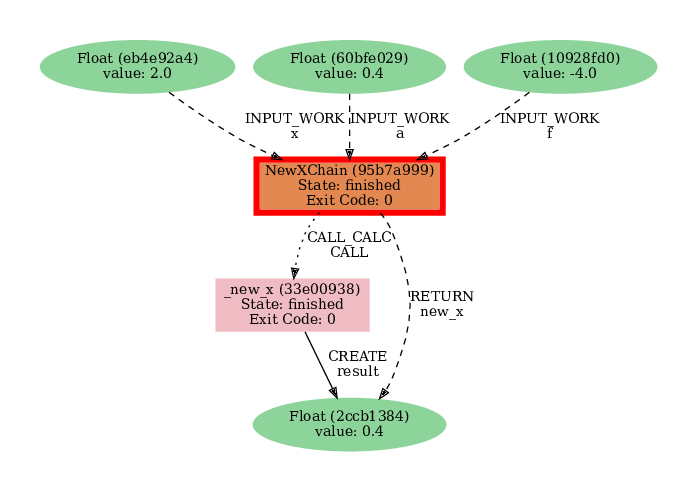

In [16]:
import subprocess
pk = future.pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

# stable_x内部のWorkChainのrun()実行

stable_x内部のWorkChainのrun()実行を行う。

In [17]:
@workfunction
def stable_x(x,a,fth):
    forcechain = WorkflowFactory("stablex.force")
    energychain = WorkflowFactory("stablex.energy")
    newxchain = WorkflowFactory("stablex.sd_new_x")
    
    x = x0
    force_builder = forcechain.get_builder()
    force_builder.x = x
    force_result, node = run.get_node(force_builder)
    f = force_result["force"]

    i = 0
    print("f,fth",f,fth)
    print("f.value,fth.value",f.value, fth.value)
    
    while np.abs(f.value) > fth.value:

        energy_builder = energychain.get_builder()
        energy_builder.x = x
        energy_result, node= run.get_node(energy_builder)        
        y = energy_result["energy"]
        print(i,"X",x,"force",f,"energy",y)   
        
        newx_builder = newxchain.get_builder()
        newx_builder.x = x
        newx_builder.f = f
        newx_builder.a = a
        newx_result, node = run.get_node(newx_builder)
        x = newx_result["new_x"]
        
        force_builder = forcechain.get_builder()
        force_builder.x = x
        force_result, node = run.get_node(force_builder)
        f = force_result["force"]        
        
        i+=1
        
    energy_builder = energychain.get_builder()
    energy_builder.x = x
    energy_result, node = run.get_node(energy_builder)
    y = energy_result["energy"]
    print("stable X",x,"force",f,"energy",y)   
    return x

x0 = Float(2)
a = Float(0.4)
fth = Float(1e-5)

stable_x =  stable_x(x0,a,fth)

f,fth uuid: 56af708e-d3e3-4716-83b2-521393f0a1f6 (pk: 9115) value: -4.0 uuid: 0760cfd5-2349-4515-9f89-8bdc8e35c186 (pk: 9111) value: 1e-05
f.value,fth.value -4.0 1e-05
0 X uuid: 8226b180-7e17-4546-9e97-61b230a5bed2 (pk: 9109) value: 2.0 force uuid: 56af708e-d3e3-4716-83b2-521393f0a1f6 (pk: 9115) value: -4.0 energy uuid: 7f541a06-634b-4414-a404-4c32dc8cc5f9 (pk: 9118) value: 4.0
1 X uuid: 88b028db-edfb-4df2-98cb-97f81c0c2405 (pk: 9121) value: 0.4 force uuid: 7c8161e6-59aa-465a-a812-075fcd80f7ff (pk: 9124) value: -0.8 energy uuid: 75980796-ddf5-4917-a624-440758c9f899 (pk: 9127) value: 0.16
2 X uuid: e477f1c8-caa3-47e3-9d1b-ed0f297dabfd (pk: 9130) value: 0.08 force uuid: 10332b5f-05de-4c5e-8ec2-0aa7bb8b584c (pk: 9133) value: -0.16 energy uuid: edd52802-42e4-4f4d-8165-4483c4791860 (pk: 9136) value: 0.0064
3 X uuid: 14174908-ce1f-4cab-966b-fffac0ae3b1c (pk: 9139) value: 0.016 force uuid: 69a18ecd-53d9-4181-8062-9e93b74a1342 (pk: 9142) value: -0.032 energy uuid: 45e7c62b-0235-4056-8825-e239f

In [18]:
stable_x

<Float: uuid: 53df34c7-2809-4740-9cb0-b8189467f6b4 (pk: 9193) value: 1.024e-06>

Success: Output written to `9193.dot.pdf`


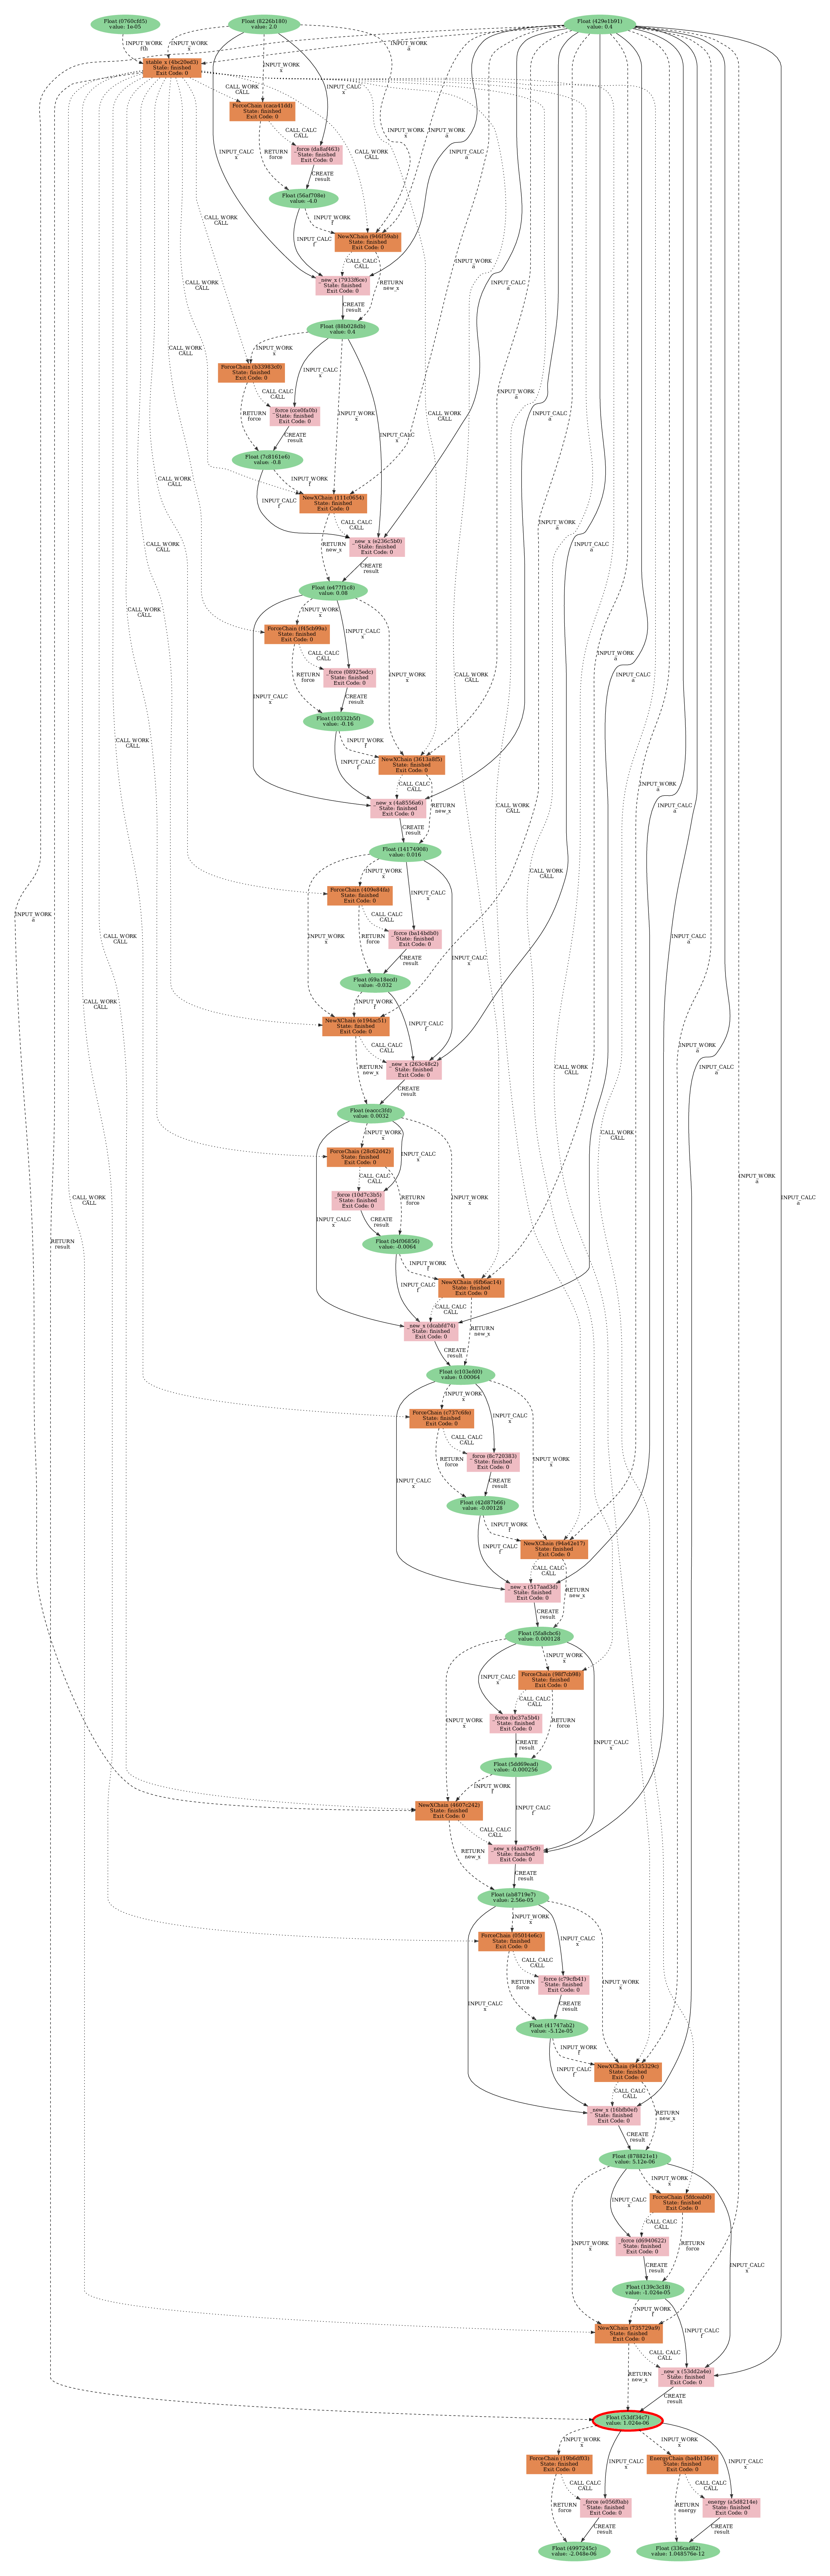

In [19]:
import subprocess
pk = stable_x.pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

# stable_x内部のWorkChainのsubmit()実行

stable_x内部のWorkChainのsubmit()実行を行う。

上で書いたとおり、WorkChainの実行が終了していなくても制御が帰ってきてしまうので、一手間必要である。

In [20]:
@workfunction
def stable_x(x,a,fth):
    manual_wait = True
    forcechain = WorkflowFactory("stablex.force")
    energychain = WorkflowFactory("stablex.energy")
    newxchain = WorkflowFactory("stablex.sd_new_x")

    force_builder = forcechain.get_builder()
    force_builder.x = x
    force_result = submit(force_builder) # <-----
    # can't wait for force_reuslt to be finished. 
    # wait it manually.
    if manual_wait:
        if not force_result.is_finished:
            time.sleep(1)
    print("force_result",force_result)
    f = force_result.outputs["force"]
    x = x0
    i = 0
    print("f,fth",f,fth)
    print("f.value,fth.value",f.value, fth.value)
    
    while np.abs(f.value) > fth.value:
        force_builder = forcechain.get_builder()
        force_builder.x = x
        force_result = submit(force_builder)
        if manual_wait:
            if not force_result.is_finished:
                time.sleep(1)
        # 簡単のためにerror処理を行わない。
        print("force_result",force_result)        
        f = force_result.outputs["force"]
        
        newx_builder = newxchain.get_builder()
        newx_builder.x = x
        newx_builder.f = f
        newx_builder.a = a
        newx_result = submit(newx_builder)
        if not newx_result.is_finished:
            time.sleep(1)
        # 簡単のためにerror処理を行わない。
        x = newx_result.outputs["new_x"]
        print("f.value",f.value)
        i+=1
        
    energy_builder = energychain.get_builder()
    energy_builder.x = x
    energy_result = submit(energy_builder)
    if manual_wait:
        if not energy_result.is_finished:
            time.sleep(1)    
    # 簡単のためにerror処理を行わない。
    y = energy_result.outputs["energy"]
    print("x,f,y",x.value,f.value,y.value)
    return x

x0 = Float(2)
a = Float(0.4)
fth = Float(1e-5)

stable_x =  stable_x(x0,a,fth)

force_result uuid: d8dd2c46-ab91-4a45-96dd-5f586a54c9ef (pk: 9204) (aiida.workflows:stablex.force)
f,fth uuid: 1938414d-1d6d-4436-96b6-512b08bcc27e (pk: 9206) value: -4.0 uuid: c74c4bb3-be69-4a9e-bdb7-01ca2b574878 (pk: 9202) value: 1e-05
f.value,fth.value -4.0 1e-05
force_result uuid: 933e2032-9643-4ffd-9972-e73546ce5fd5 (pk: 9207) (aiida.workflows:stablex.force)
f.value -4.0
force_result uuid: 398989bf-5469-4fc4-987c-91c1767a15a1 (pk: 9213) (aiida.workflows:stablex.force)
f.value -0.8
force_result uuid: 034a7e6f-d477-4f45-a261-8a48c77bc912 (pk: 9219) (aiida.workflows:stablex.force)
f.value -0.16
force_result uuid: 88b63586-146e-4b4e-9674-b871d8d7a7a1 (pk: 9225) (aiida.workflows:stablex.force)
f.value -0.032
force_result uuid: 315402bd-5330-4369-ab18-c024f54940cf (pk: 9231) (aiida.workflows:stablex.force)
f.value -0.0064
force_result uuid: 084ca3db-f42e-4fc8-9715-8a51913e05bd (pk: 9237) (aiida.workflows:stablex.force)
f.value -0.00128
force_result uuid: b93ecc08-edbc-4f8b-909d-40247f1e

次にstable_x部分をWorkChain化する。

ｰ>上の面倒さが減る。
